# Variational Auto Encoder 1 - MNIST

1. Data load
2. Encoder
3. Sampling function
4. Decoder
5. Loss
6. Build model
7. Train model
8. Plot latent space inputs in 2D
9. Build digit generator
10. Display a 2D manifold of digits

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Data load

In [2]:
# Get data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Re-scale data
x_train, x_test = x_train.astype(np.float32) / 255, x_test.astype(np.float32) / 255
# Reshape data
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)

## 2. Encoder

Takes in the input vector x, and returns two latent vectors representing the mean and standard deviation, mu and sigma.

In [3]:
enc_inputs = Input(shape=(784,))
enc_hidden_1 = Dense(256, activation='relu')(enc_inputs)
enc_hidden_2 = Dense(128, activation='relu')(enc_hidden_1)
mu = Dense(2)(enc_hidden_2)
logsigma = Dense(2)(enc_hidden_2)
Model(enc_inputs, [mu, logsigma]).summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            258         dense_1[0][0]                    
_____________

## 3. Sampling function

Takes in the mu and sigma vectors and gives back a sampled latent vector z.

In [4]:
def sampling(args):
    mu, logsigma = args
    eps = K.random_normal(shape=(100, 2), mean=0, stddev=1.0)
    return mu + K.exp(logsigma) * eps

z = Lambda(sampling, output_shape=(2,))([mu, logsigma])
Model(enc_inputs, z).summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            258         dense_1[0][0]                    
____________________________________________________________________________________________

## 4. Decoder

Takes in the sampled z vector, and gives back a 784 sized image vector.

In [5]:
h_dec_1 = Dense(256, activation='relu')
h_dec_2 = Dense(256, activation='relu')
h_hat_dec = Dense(784, activation='sigmoid')

z_decoder = h_dec_1(z)
z_decoder = h_dec_2(z_decoder)
dec_outputs = h_hat_dec(z_decoder)
Model(enc_inputs, dec_outputs).summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            258         dense_1[0][0]                    
____________________________________________________________________________________________

## 5. Loss

In [6]:
def loss(enc_inputs, dec_outputs):
    #reconstruction_loss = losses.mse(enc_inputs, dec_outputs)
    reconstruction_loss = losses.binary_crossentropy(enc_inputs, dec_outputs)
    #reconstruction_loss = -.5 * K.sum(1. + logsigma - K.square(
        #mu) - K.exp(logsigma), axis=-1)
    reconstruction_loss *= 784
    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(logsigma) - logsigma - 1, axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    return vae_loss

## 6. Build model

In [7]:
vae = Model(enc_inputs, dec_outputs)
vae.compile(optimizer='rmsprop', loss=loss)
vae.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            258         dense_1[0][0]                   

## 7. Train model

In [8]:
history = vae.fit(x_train,
    x_train,
    shuffle=True,
    epochs=100,
    batch_size=100,
    validation_data=(x_test, x_test),
    verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 41us/sample - loss: 187.2643 - val_loss: 166.8241
Epoch 2/100
60000/60000 [==============================] - 1s 23us/sample - loss: 162.0637 - val_loss: 158.6793
Epoch 3/100
60000/60000 [==============================] - 1s 23us/sample - loss: 155.1486 - val_loss: 153.2167
Epoch 4/100
60000/60000 [==============================] - 1s 23us/sample - loss: 151.1657 - val_loss: 150.0794
Epoch 5/100
60000/60000 [==============================] - 2s 27us/sample - loss: 148.5451 - val_loss: 147.9345
Epoch 6/100
60000/60000 [==============================] - 1s 24us/sample - loss: 146.5959 - val_loss: 147.2266
Epoch 7/100
60000/60000 [==============================] - 1s 23us/sample - loss: 145.2645 - val_loss: 144.6559
Epoch 8/100
60000/60000 [==============================] - 2s 25us/sample - loss: 144.1128 - val_loss: 144.2931
Epoch 9/100
60000/60000 [=============================

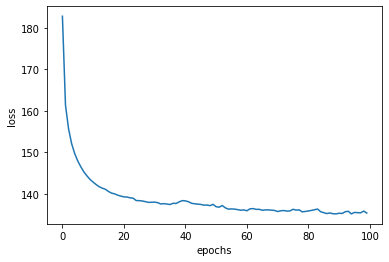

In [9]:
# Plot loss
loss = history.history['loss']
plt.plot(loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## 8. Plot latent space inputs in 2D

In [10]:
encoder = Model(enc_inputs, mu)
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


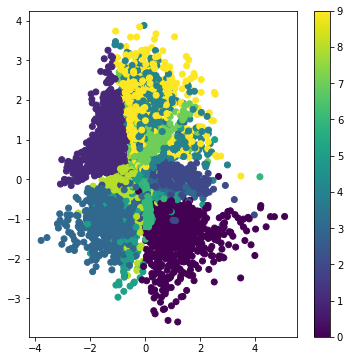

In [11]:
x_to_latent = encoder.predict(x_test, batch_size=100)
plt.figure(figsize=(6, 6))
plt.scatter(x_to_latent[:, 0], x_to_latent[:, 1], c=y_test)
plt.colorbar()
plt.show()

## Build a digit generator and sample single digits from normal 

In [12]:
# Build decoder
dec_inputs = Input(shape=(100, 2))
decoder = h_dec_1(dec_inputs)
decoder = h_dec_2(decoder)
dec_outputs = h_hat_dec(decoder)
decoder = Model(dec_inputs, dec_outputs)
decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
dense_4 (Dense)              multiple                  768       
_________________________________________________________________
dense_5 (Dense)              multiple                  65792     
_________________________________________________________________
dense_6 (Dense)              multiple                  201488    
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


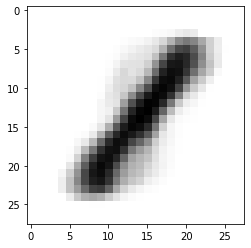

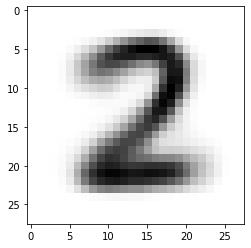

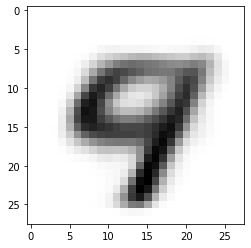

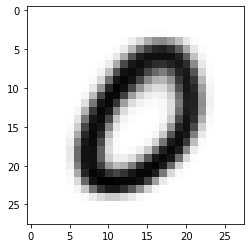

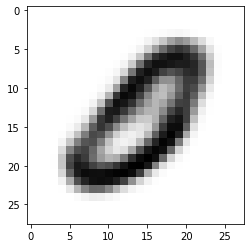

In [53]:
# Generate x_hats
_z = np.random.normal(loc=0, scale=1, size=(1, 100, 2))
#_z = np.array([grid_x[3], grid_y[3]])
x_hat = decoder.predict(_z)
x_hat = x_hat.reshape(100, 28, 28)

# Display x_hat as images
for i in range(5):
    plt.imshow(x_hat[i], cmap='gray_r')
    plt.show()

## 10. Display a 2D manifold

In [57]:
# Setup a coordinate grid
n = 10
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

b = []
for i in grid_y:
    for j in grid_x:
        b.append([i, j])
__z = np.reshape(np.array(b), (1, 100, 2))
__z.shape

(1, 100, 2)

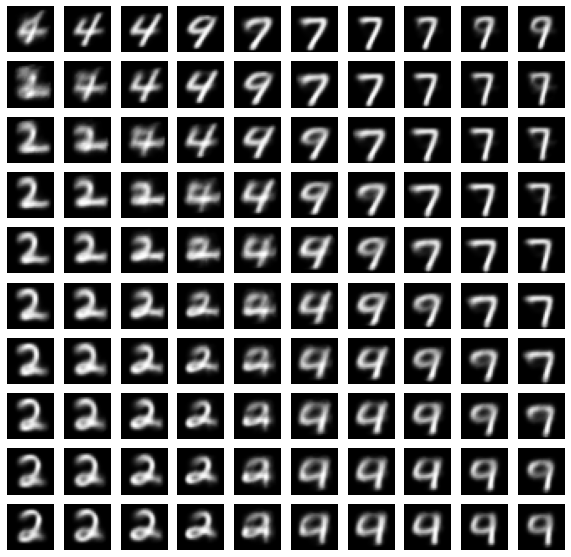

In [58]:
x_hat = decoder.predict(__z)
x_hat = x_hat.reshape(100, 28, 28)

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    img = x_hat[i]
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(img[:, :], cmap='gray')
plt.show()